<a href="https://colab.research.google.com/github/Noam2710/StyleGAN_Interpolation/blob/master/Copy_of_style_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating High Rez GAN Faces with Google CoLab

This notebook demonstrates how to run [NVidia StyleGAN](https://github.com/NVlabs/stylegan) inside of a Google CoLab notebook.  I suggest you use this to generate GAN faces from a pretrained model.  If you try to train your own, you will run into compute limitations of Google CoLab.

Make sure to run this code on a GPU instance.  GPU is assumed.

This is from my [class on deep learning](  https://www.youtube.com/watch?v=EQ38k6z2aks&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)

[Jeff Heaton](https://www.heatonresearch.com/)

# Instructions

First, map your G-Drive, this is where your GANs will be written to.

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!git clone https://github.com/NVlabs/stylegan.git

Cloning into 'stylegan'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), done.


In [0]:
import sys
sys.path.insert(0, "/content/stylegan")

import dnnlib
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib.tflib as tflib
import config

In [0]:
tflib.init_tf()
with open('/content/drive/My Drive/karras2019stylegan-ffhq-1024x1024.pkl', "rb") as f:
  _G, _D, Gs = pickle.load(f)











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
rnd = np.random.RandomState()
latents = rnd.randn(2, Gs.input_shape[1])
dest_latent = latents[1,:].reshape((1,512))
source_latent = latents[0,:].reshape((1,512))

In [0]:
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
source_image = np.squeeze(Gs.run(source_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
dest_image = np.squeeze(Gs.run(dest_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))

Source image


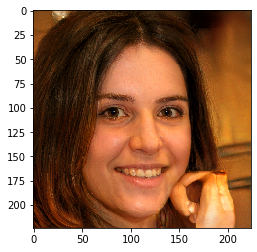

Destination image


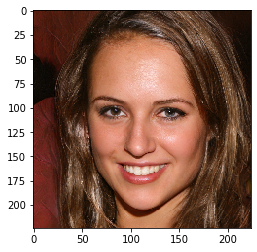

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import cv2
from matplotlib import pyplot as plt
print("Source image")
source_res = cv2.resize(np.squeeze(source_image), dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(source_res)
plt.show()
print("Destination image")
dest_res = cv2.resize(np.squeeze(dest_image), dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(dest_res)
plt.show()

In [0]:
!pip install evostra
from evostra import EvolutionStrategy

  Created wheel for evostra: filename=evostra-2.5.2-py2.py3-none-any.whl size=5628 sha256=59b6cf3e85db274827e41ed971fe2da551b27f70a6347b42b31737d2a4834435
  Stored in directory: /root/.cache/pip/wheels/8a/d2/0a/19e1279290da14ce7c3d25589e21f264037ac9fb38ae18aa55
Successfully built evostra


In [0]:
# def get_reward_distance_between_latensts(latent_vector):
#   return -np.linalg.norm(latent_vector[0] - dest_latent)

# def get_reward_distance_between_images(latent_vector):
#   image_to_check = np.squeeze(Gs.run(latent_vector[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
#   image_after_resize = cv2.resize(image_to_check, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
#   return -np.square(np.subtract(image_after_resize, dest_res)).mean()

In [0]:
# pip install git+https://github.com/rcmalli/keras-vggface.git

In [0]:
pip install keras_vggface

In [0]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

# # vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max
# vgg_features = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max
# # vgg_features = VGGFace(model='senet50', include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max

Using TensorFlow backend.


In [0]:
from keras_vggface import utils
from keras.preprocessing import image
from datetime import datetime

def predict_features_from_image(res):
  res = image.img_to_array(res)
  res = np.expand_dims(res, axis=0)
  res = utils.preprocess_input(res, version=2) # or version=2
  return vgg_features.predict(res)

In [0]:
def get_reward_by_vgg(latent_vector):
  image_to_check = np.squeeze(Gs.run(latent_vector[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
  image_after_resize = cv2.resize(image_to_check, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  image_to_check_features = predict_features_from_image(image_after_resize)
  return -np.linalg.norm(image_to_check_features - features_of_dest_images)

In [0]:
def get_rewared_by_vgg_cosine(latent_vector):
  image_to_check = np.squeeze(Gs.run(latent_vector[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
  image_after_resize = cv2.resize(image_to_check, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  image_to_check_features = predict_features_from_image(image_after_resize)
  return cosine_similarity(np.squeeze(image_to_check_features),np.squeeze(features_of_dest_images))*50

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

In [0]:
def run_es_model(verbose=False):
  global features_of_dest_images
  features_of_dest_images = predict_features_from_image(dest_res)
  init_latent_vector = [source_latent]
  source_image = Gs.run(source_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
  res = cv2.resize(np.squeeze(source_image), dsize=(600, 600), interpolation=cv2.INTER_CUBIC)
  list_of_images = [cv2.cvtColor(res, cv2.COLOR_BGR2RGB)]
  list_of_vectors = []
  list_of_rewards = []
  es = EvolutionStrategy(init_latent_vector, get_reward_by_vgg, population_size=50, sigma=0.5, learning_rate=0.1, num_threads=1)
  run_each_time = 5
  total_runs = 600
  for i in range (int(total_runs/run_each_time)):
    print("Iterations {} - {} | Reward {}".format(i*run_each_time,(i+1)*run_each_time,es.get_reward(es.get_weights())))
    es.run(run_each_time,print_step=run_each_time*10000)
    list_of_rewards.append(es.get_reward(es.get_weights()))
    list_of_vectors.append(np.squeeze(es.get_weights()[0]))
    images = Gs.run(es.get_weights()[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
    res = cv2.resize(np.squeeze(images), dsize=(600, 600), interpolation=cv2.INTER_CUBIC)
    if verbose:
      plt.imshow(res)
      plt.show()
    list_of_images.append(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
  return list_of_images,list_of_vectors,list_of_rewards

In [0]:
# def list_of_images_to_video(model_name,date_time):  
#   out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'mp4v'), 5, (600,600))
#   for i in range(len(list_of_images)):
#       out.write(list_of_images[i])
#   out.release()

#   !mv 'project.avi' '/content/drive/My Drive/videos_of_transformation'
#   os.rename('/content/drive/My Drive/videos_of_transformation/project.avi', '/content/drive/My Drive/videos_of_transformation/{}-{}.avi'.format(model_name,date_time))



58916864/58909280 [==============================] - 5s 0us/step


Iterations 0 - 5 | Reward -82.41300964355469
Iterations 5 - 10 | Reward -75.29019927978516
Iterations 10 - 15 | Reward -72.0504150390625
Iterations 15 - 20 | Reward -65.37916564941406
Iterations 20 - 25 | Reward -59.761810302734375
Iterations 25 - 30 | Reward -59.70098876953125
Iterations 30 - 35 | Reward -56.78618621826172
Iterations 35 - 40 | Reward -53.93645477294922
Iterations 40 - 45 | Reward -51.74087142944336
Iterations 45 - 50 | Reward -50.34994125366211
Iterations 50 - 55 | Reward -49.91514587402344
Iterations 55 - 60 | Reward -49.07089614868164
Iterations 60 - 65 | Reward -47.41959762573242
Iterations 65 - 70 | Reward -45.819217681884766
Iterations 70 - 75 | Reward -45.86540222167969
Iterations 75 - 80 | Reward -42.75935745239258
Iterations 80 - 85 | Reward -41.791263580322266
Iterations 85 - 90 | Reward -40.89693069458008
Iterations 90 - 95 | Reward -40.618534088134766
Iterations 95 - 100 | Reward -39.09523

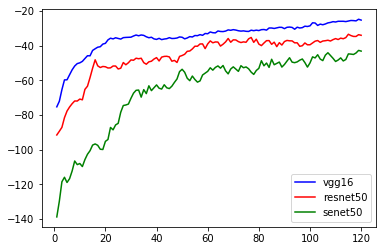

In [0]:
features_of_dest_images = None
list_of_models = ['vgg16','resnet50','senet50']
model_to_vectors = {}
model_to_rewards = {}
for model in list_of_models:
  now = datetime.now() # current date and time
  date_time = now.strftime("%m-%d-%Y-%H-%M-%S")
  vgg_features = VGGFace(model=model, include_top=False, input_shape=(224, 224, 3), pooling='avg')
  images_list,vectors_list,reward_list = run_es_model(verbose=False)

  out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'mp4v'), 5, (600,600))
  for i in range(len(images_list)):
      out.write(images_list[i])
  out.release()

  !mv 'project.avi' '/content/drive/My Drive/videos_of_transformation'
  os.rename('/content/drive/My Drive/videos_of_transformation/project.avi', '/content/drive/My Drive/videos_of_transformation/{}-{}.avi'.format(model,date_time))


  # list_of_images_to_video(images_list,date_time)
  model_to_vectors[model] = vectors_list
  model_to_rewards[model] = reward_list

plt.plot(list(range(1,len(model_to_rewards[list_of_models[0]])+1)),model_to_rewards[list_of_models[0]], 'b', label=list_of_models[0])
plt.plot(list(range(1,len(model_to_rewards[list_of_models[1]])+1)),model_to_rewards[list_of_models[1]], 'r', label=list_of_models[1])
plt.plot(list(range(1,len(model_to_rewards[list_of_models[2]])+1)),model_to_rewards[list_of_models[2]], 'g', label=list_of_models[2])
plt.legend()
plt.show()

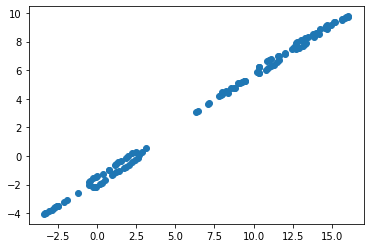

In [0]:
latents_to_tnse = np.stack(model_to_rewards[list_of_models[1]], axis=0)
X_embedded = TSNE(n_components=2).fit_transform(latents_to_tnse.reshape((120,1)))
plt.scatter(X_embedded[:,0], X_embedded[:,1])

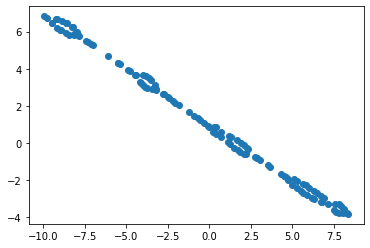

In [0]:
latents_to_tnse = np.stack(model_to_rewards[list_of_models[2]], axis=0)
X_embedded = TSNE(n_components=2).fit_transform(latents_to_tnse.reshape((120,1)))
plt.scatter(X_embedded[:,0], X_embedded[:,1])

In [0]:
latents_to_tnse = np.stack(model_to_rewards[list_of_models[2]], axis=0)
X_embedded = TSNE(n_components=2).fit_transform(latents_to_tnse)
plt.scatter(X_embedded[:,0], X_embedded[:,1])